In [1]:
from deep_learning_lab.data_preparation import Orchestrator
from deep_learning_lab.model import Trainer, Predictor
import deep_learning_lab.gpu_setup as gpu

from PIL import Image
import matplotlib.pyplot as plt
import os

# Training data preparation

## Download datasets

In [ ]:
"""
%%sh
cat download_data.sh
./download_data.sh
"""

## Patch the datasets

In [3]:
Orchestrator.DATASETS.keys()

dict_keys(['reid', 'fcr', 'bcs_a', 'bcs_b', 'bcs_e', 'bcs_h', 'bcs_n', 'bcs_s', 'bcs_u', 'bcs_un', 'bcc_a', 'bcc_b', 'bcc_bh', 'bcc_e', 'bcc_h', 'bcc_n', 'bcc_s', 'bcc_u', 'bcc_un'])

In [ ]:
sets_labels = [['ImageRegion'], ['TextLine'], ['TextRegion']] # Atomic labels are to be promoted

# Create an instance of Orchestrator and specify the output directory structure
orc = Orchestrator(
    output_structure= {'dir_data': "training_data",
                       'dir_images': "images",
                       'dir_labels': "labels"}
)

# Ingest any datasets and add default settings
orc.ingestDatasets(
    datasets= [],
    add_defaults= True
)

# Loop through each set of labels
for set_labels in sets_labels:
    # Ingest the labels and prompt for additional labels if needed
    orc.ingestLabels(
        uniform_set_labels= set_labels,
        prompt= False
    )
    
    # Validate the labels automatically and suppress verbose output
    orc.validate(
        auto_yes= True,
        verbose= 0
    )
    
    # Preprocess the data by resizing images and labels
    orc.preprocess(
        resize= (841, 1188), # To have 1e6 pixels and tensors of same size
        overwrite= False,
        verbose= 2
    )

    print()

# Deep learning lab

In [2]:
# Select a CUDA device to use for computation
gpu.cudaDeviceSelection(preselected_device= 0)

# Print information about the selected CUDA device
print(gpu.cudaInfo())

Torch (1.12.1)
CUDA (11.3)
GPU (RTX A6000)
CUDA memory (48.69 GB)


## Training

In [3]:
labels = ['TextLine']

In [4]:
trainer = Trainer(
    labels, # a list of labels for the training data
    input_dir= "training_data", # the directory where the training data is stored
    workdir= "results", # the directory where results will be saved
    train_ratio= 0.80, # the ratio of data to be used for training
    val_ratio= 0.10 # the ratio of data to be used for validation
)

In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

tensorboard_dir = trainer.tensorboard_dir
!echo $tensorboard_dir
#!rm -r $tensorboard_dir & mkdir -p $tensorboard_dir
%tensorboard --logdir $tensorboard_dir

results/TextLine/tensorboard/log


In [ ]:
trainer.train(
    batch_size= 4, # the number of samples to use in each batch during training
    epochs= 100, # the number of epochs to train the model for
    learning_rate= 1e-4, # the rate at which the model adjusts its weights during training
    gamma_exp_lr= 0.9995, # the decay rate for the learning rate during training
    evaluate_every_epoch= 5, # how often to evaluate the model on the validation set during training
    val_patience= 4, # how many epochs to wait for improvement in validation loss before early stopping
    repeat_dataset= 4, # how many times to repeat the training data during each epoch
    output_size= 1e6 # the size of the images
)

## Inference

In [2]:
labels = ['TextLine']

In [3]:
predictor = Predictor(
    labels, # a list of labels for the predicted classes
    input_dir= 'inference_data', # the directory containing the input images to predict on
    output_dir= None, # the directory to save the predicted images to (if None, saves to 'predictions')
    output_size= None, # the size of the predicted images (if None, uses input image size)
    from_csv= os.path.join('training_data', 'test.csv'), # is the path to a CSV file with input image paths and labels
    reset_from_csv= True # whether to reset the input before starting the predictor
)

results = predictor.start(
    batch_size= 4, # the number of images to process at once
    drawRegions= True, # whether to draw regions on the images
    cutVignettes= True, # whether to cut out vignettes from the images
    bounding_box= False, # whether to use a bounding box or a polygon around the predicted regions
    verbose= True # whether to print status messages
)

{'data': {'type': 'folder', 'folder': 'results/TextLine/inference_data', 'pre_processing': {'transforms': []}}, 'model': {'model': {'encoder': 'resnet50', 'decoder': {'decoder_channels': [512, 256, 128, 64, 32], 'max_channels': 512}}, 'num_classes': 2, 'model_state_dict': 'results/TextLine/model/best_model_checkpoint_miou=0.544.pth', 'device': 'cuda:0'}, 'batch_size': 4, 'add_path': True} data
{'folder': 'results/TextLine/inference_data', 'pre_processing': {'transforms': []}} folder
{'transforms': []} transforms
{'model': {'model': {'encoder': 'resnet50', 'decoder': {'decoder_channels': [512, 256, 128, 64, 32], 'max_channels': 512}}, 'num_classes': 2, 'model_state_dict': 'results/TextLine/model/best_model_checkpoint_miou=0.544.pth', 'device': 'cuda:0'}, 'batch_size': 4, 'add_path': True} model
{'model': {'encoder': 'resnet50', 'decoder': {'decoder_channels': [512, 256, 128, 64, 32], 'max_channels': 512}}, 'num_classes': 2, 'model_state_dict': 'results/TextLine/model/best_model_checkpoi

  0%|          | 0/24 [00:00<?, ?it/s]

Post-processing predictions : 100%|██████████| 96/96 [00:36<00:00,  2.63it/s]


## Tests

In [4]:
assert len(results)

In [5]:
results[0].keys()

dict_keys(['probas', 'path', 'name', 'probasMaps', 'labels', 'image', 'regions', 'vignettes'])

In [6]:
image_nb = 0
predictions = results[image_nb]

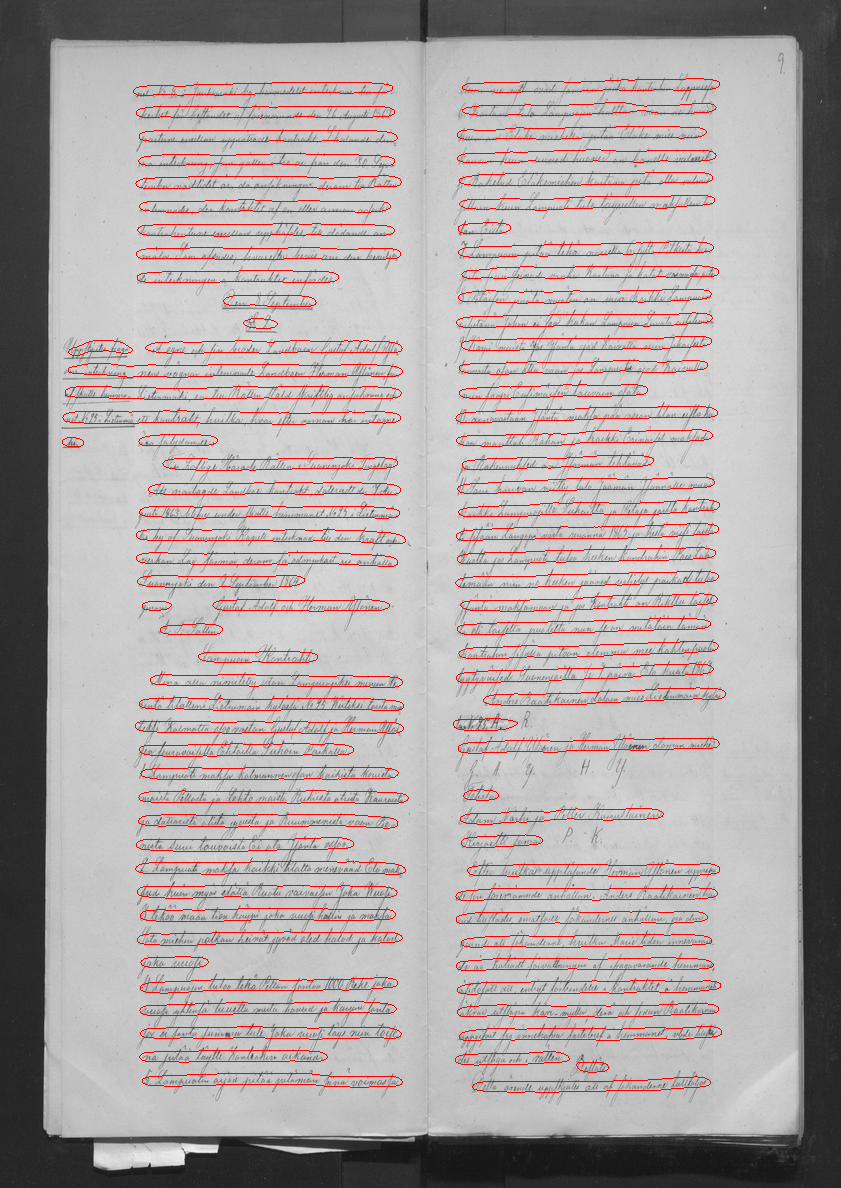

In [7]:
# Show the regions found on the original image
Image.fromarray(predictions['regions'])

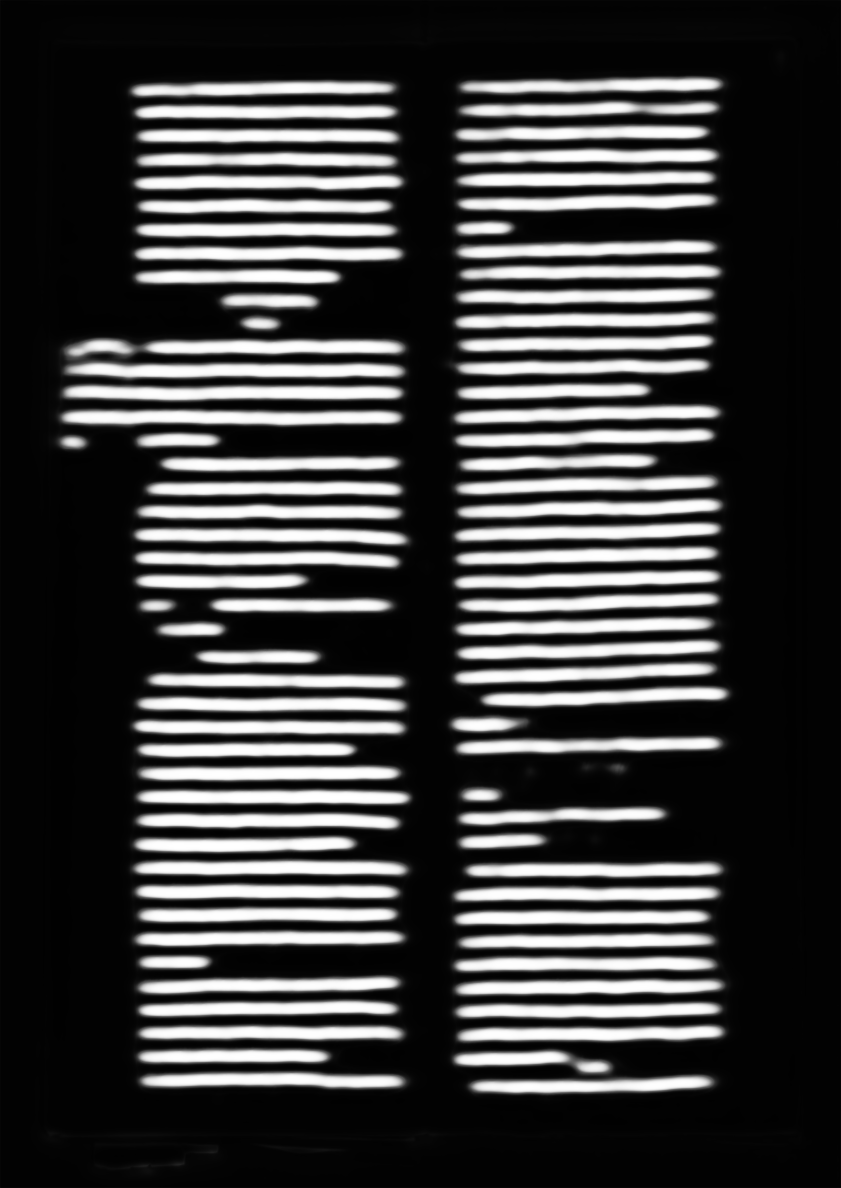

In [8]:
# Show the probability map of the class 1
Image.fromarray(predictions['probasMaps'][1])

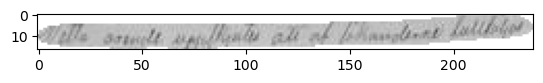

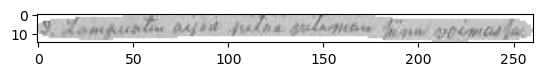

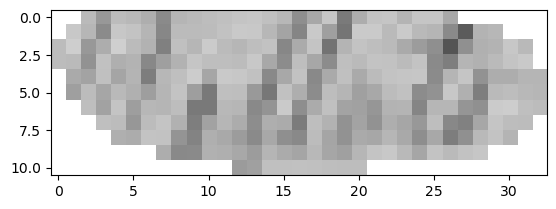

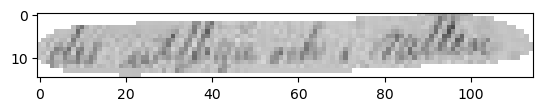

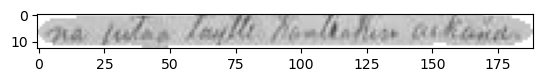

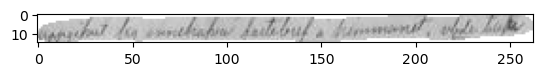

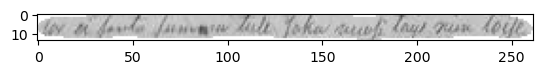

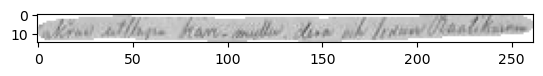

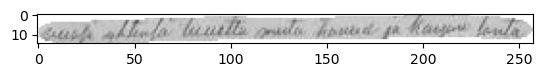

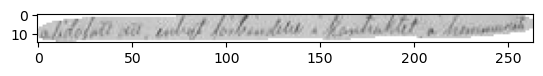

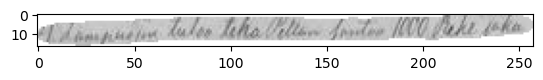

In [10]:
# Show the regions found
for it, vignette in enumerate(predictions['vignettes']):
    plt.imshow(Image.fromarray(vignette))
    plt.show()
    if it == 10: break